### CSCT Masters Project 23Sep-UFCF9Y-60-M
#### Student_Number:23044930
#### Title: Interactive Framework for Bias Detection and Mitigation in Machine Learning Models Using Fairness Constraints.

In [9]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:

# Specify the path to your uploaded CSV file
file_path = r'C:\Users\SAM\Desktop\CSCT Master Project/adult.csv'

try:
    # Attempt to load the data from the file
    data = pd.read_csv(file_path)
    
    # Preprocess the dataset
    # Replace placeholder '?' with NaN and drop rows with missing values
    data = data.replace('?', pd.NA).dropna()
    
    # Display the first few rows of the dataset
    display(data.head())
    
except pd.errors.EmptyDataError:
    print("The uploaded file is empty or malformed.")
except FileNotFoundError:
    print(f"File not found: {file_path}")


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
# Encode categorical columns and retain the mapping for the sensitive feature

def encode_columns(data, sensitive_feature_column):
    """Encodes categorical columns in the dataset and keeps the mapping for the sensitive feature.
    
    Args:
        data: The dataset as a pandas DataFrame.
        sensitive_feature_column: The column name of the sensitive feature.

    Returns:
        data_encoded: The encoded dataset.
        sensitive_feature_mapping: A dictionary mapping encoded values to original categories for the sensitive feature.
    """
    # Create a copy of the dataset to avoid modifying the original data
    data_encoded = data.copy()
    
    # Encode all categorical features except the sensitive feature
    for column in data_encoded.columns:
        if data_encoded[column].dtype == object and column != sensitive_feature_column:
            data_encoded[column] = LabelEncoder().fit_transform(data_encoded[column])
    
    # Encode the sensitive feature and retain the mapping of the original categories
    le = LabelEncoder()
    data_encoded[sensitive_feature_column] = le.fit_transform(data_encoded[sensitive_feature_column])
    sensitive_feature_mapping = dict(zip(le.transform(le.classes_), le.classes_))
    
    return data_encoded, sensitive_feature_mapping

# Example usage:
sensitive_feature_column = 'sex'  # Replace with your actual sensitive feature column name
data_encoded, sensitive_feature_mapping = encode_columns(data, sensitive_feature_column)

# Display the encoded data and the mapping for the sensitive feature 
display(data_encoded.head())
print("Sensitive Feature Mapping:", sensitive_feature_mapping)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


Sensitive Feature Mapping: {0: ' Female', 1: ' Male'}


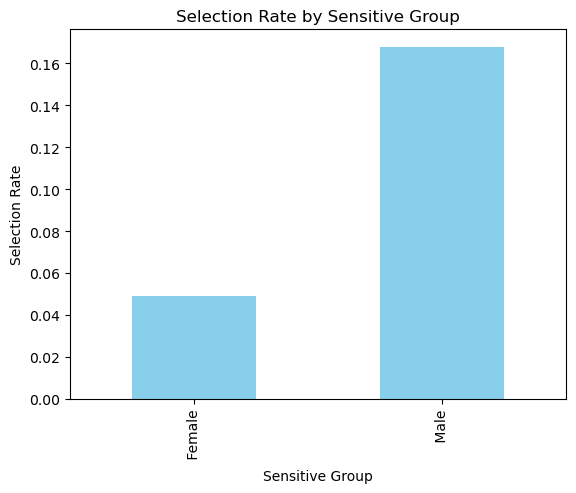

Disparate Impact: 0.29
Bias Percentage: 70.78%


In [8]:
#Initial Bias Check using logistic regression to identify bias
def check_bias_logistic_regression(data, target_column, sensitive_feature_column, sensitive_feature_mapping):
    """Performs an initial bias check using Logistic Regression.
    
    Args:
        data: The dataset as a pandas DataFrame.
        target_column: The column name of the target variable.
        sensitive_feature_column: The column name of the sensitive feature.
        sensitive_feature_mapping: The mapping of encoded values to original categories for the sensitive feature.
    
    Returns:
        A dictionary containing the results of the bias analysis, including disparate impact and bias percentage.
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
        data.drop(target_column, axis=1), data[target_column], data[sensitive_feature_column], 
        test_size=0.25, random_state=42
    )

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Define fairness metrics to evaluate the model's performance across different groups
    metrics = {
        'selection_rate': selection_rate,
        'true_positive_rate': true_positive_rate,
        'true_negative_rate': true_negative_rate,
        'false_positive_rate': false_positive_rate,
        'false_negative_rate': false_negative_rate
    }

    # Create a MetricFrame to evaluate the model's fairness across sensitive groups
    metric_frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test)
    
    # Get the selection rate by group from the metric frame
    sr_by_group = metric_frame.by_group['selection_rate']

    # Map the numeric index back to the original category labels
    sr_by_group.index = sr_by_group.index.map(lambda x: sensitive_feature_mapping[x])

    # Calculate disparate impact and bias percentage for the sensitive feature
    disparate_impact = sr_by_group.min() / sr_by_group.max()
    bias_percentage = (1 - disparate_impact) * 100

    # Plot the selection rate across different sensitive groups
    sr_by_group.plot(kind='bar', color='skyblue')
    plt.title('Selection Rate by Sensitive Group')
    plt.ylabel('Selection Rate')
    plt.xlabel('Sensitive Group')
    plt.show()

    # Return the model, metric frame, and calculated bias metrics for further analysis
    return {
        "Disparate Impact": disparate_impact,
        "Bias Percentage": bias_percentage,
        "Metric Frame": metric_frame
    }

# Example usage:
target_column = 'income'  # Replace with your actual target column name
sensitive_feature_column = 'sex'  # Replace with your actual sensitive feature column name

bias_results = check_bias_logistic_regression(data_encoded, target_column, sensitive_feature_column, sensitive_feature_mapping)

# Display the results of the bias analysis
print(f"Disparate Impact: {bias_results['Disparate Impact']:.2f}")
print(f"Bias Percentage: {bias_results['Bias Percentage']:.2f}%")

In [10]:
#Bias mitigation based on the machine learning models trained.
def apply_fairness_constraints(data, target_column, sensitive_feature_column, constraint_option):
    """Trains multiple machine learning models and applies the selected fairness constraint.
    
    Args:
        data: The dataset as a pandas DataFrame.
        target_column: The column name of the target variable.
        sensitive_feature_column: The column name of the sensitive feature.
        constraint_option: The fairness constraint to be applied (Demographic Parity or Equalized Odds).
    """
    # Define features (X) and the target variable (y) for the models
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    sensitive_feature = data[sensitive_feature_column]

    # Define the machine learning models to be trained
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier()
    }

    # Train and evaluate each model separately
    for model_name, model in models.items():
        print(f"## {model_name}")
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
            X, y, sensitive_feature, test_size=0.25, random_state=42)

        # Train the model on the training set
        model.fit(X_train, y_train)
        
        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Calculate initial fairness metrics before bias mitigation
        metrics = {
            'selection_rate': selection_rate,
            'true_positive_rate': true_positive_rate,
            'true_negative_rate': true_negative_rate,
            'false_positive_rate': false_positive_rate,
            'false_negative_rate': false_negative_rate
        }
        metric_frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test)
        sr_by_group = metric_frame.by_group['selection_rate']
        disparate_impact = sr_by_group.min() / sr_by_group.max()
        bias_percentage = (1 - disparate_impact) * 100

        # Display the original accuracy and fairness metrics
        print(f"**Original Accuracy**: {accuracy_score(y_test, y_pred):.4f}")
        print(f"**Original Bias Percentage**: {bias_percentage:.4f}%")
        print(f"**Original Disparate Impact**: {disparate_impact:.4f}")

        # Apply the selected fairness constraint to mitigate bias
        if constraint_option == "Demographic Parity":
            constraint = DemographicParity()
        else:
            constraint = EqualizedOdds()

        # Use ExponentiatedGradient to apply the fairness constraint and retrain the model
        mitigator = ExponentiatedGradient(model, constraint)
        mitigator.fit(X_train, y_train, sensitive_features=sensitive_train)
        y_pred_mitigated = mitigator.predict(X_test)

        # Calculate metrics after bias mitigation
        accuracy_mitigated = accuracy_score(y_test, y_pred_mitigated)
        precision = precision_score(y_test, y_pred_mitigated)
        recall = recall_score(y_test, y_pred_mitigated)
        f1 = f1_score(y_test, y_pred_mitigated)

        # Evaluate fairness metrics after bias mitigation
        metric_frame_mitigated = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=sensitive_test)
        sr_by_group_mitigated = metric_frame_mitigated.by_group['selection_rate']
        disparate_impact_mitigated = sr_by_group_mitigated.min() / sr_by_group_mitigated.max()
        bias_percentage_mitigated = (1 - disparate_impact_mitigated) * 100

        # Display the mitigated accuracy and fairness metrics
        print(f"**Mitigated Accuracy**: {accuracy_mitigated:.4f}")
        print(f"**Mitigated Bias Percentage**: {bias_percentage_mitigated:.4f}%")
        print(f"**Mitigated Disparate Impact**: {disparate_impact_mitigated:.4f}")
        print(f"**Precision**: {precision:.4f}")
        print(f"**Recall**: {recall:.4f}")
        print(f"**F1 Score**: {f1:.4f}")
        print("-" * 50)  # Divider between models

# Example usage:
constraint_option = "Demographic Parity"  # or "Equalized Odds"
apply_fairness_constraints(data_encoded, target_column, sensitive_feature_column, constraint_option)

## Logistic Regression
**Original Accuracy**: 0.8090
**Original Bias Percentage**: 70.7765%
**Original Disparate Impact**: 0.2922
**Mitigated Accuracy**: 0.7988
**Mitigated Bias Percentage**: 42.8150%
**Mitigated Disparate Impact**: 0.5718
**Precision**: 0.7567
**Recall**: 0.2211
**F1 Score**: 0.3422
--------------------------------------------------
## Decision Tree
**Original Accuracy**: 0.8119
**Original Bias Percentage**: 60.0671%
**Original Disparate Impact**: 0.3993
**Mitigated Accuracy**: 0.7600
**Mitigated Bias Percentage**: 1.1697%
**Mitigated Disparate Impact**: 0.9883
**Precision**: 0.4946
**Recall**: 0.6430
**F1 Score**: 0.5591
--------------------------------------------------
## Random Forest
**Original Accuracy**: 0.8616
**Original Bias Percentage**: 68.0687%
**Original Disparate Impact**: 0.3193
**Mitigated Accuracy**: 0.8009
**Mitigated Bias Percentage**: 5.9206%
**Mitigated Disparate Impact**: 0.9408
**Precision**: 0.5705
**Recall**: 0.6424
**F1 Score**: 0.6043
------

In [11]:
# Example usage:
constraint_option = "Equalized Odds"  
apply_fairness_constraints(data_encoded, target_column, sensitive_feature_column, constraint_option)

## Logistic Regression
**Original Accuracy**: 0.8090
**Original Bias Percentage**: 70.7765%
**Original Disparate Impact**: 0.2922
**Mitigated Accuracy**: 0.8060
**Mitigated Bias Percentage**: 59.8344%
**Mitigated Disparate Impact**: 0.4017
**Precision**: 0.7214
**Recall**: 0.2942
**F1 Score**: 0.4180
--------------------------------------------------
## Decision Tree
**Original Accuracy**: 0.8128
**Original Bias Percentage**: 60.4778%
**Original Disparate Impact**: 0.3952
**Mitigated Accuracy**: 0.8084
**Mitigated Bias Percentage**: 59.4070%
**Mitigated Disparate Impact**: 0.4059
**Precision**: 0.5921
**Recall**: 0.6124
**F1 Score**: 0.6020
--------------------------------------------------
## Random Forest
**Original Accuracy**: 0.8608
**Original Bias Percentage**: 69.1991%
**Original Disparate Impact**: 0.3080
**Mitigated Accuracy**: 0.8605
**Mitigated Bias Percentage**: 70.1827%
**Mitigated Disparate Impact**: 0.2982
**Precision**: 0.7419
**Recall**: 0.6295
**F1 Score**: 0.6811
----